In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytensor

floatX = "float32"
pytensor.config.floatX = floatX

In [3]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from pytensor_ml.activations import LeakyReLU
from pytensor_ml.layers import Linear, Sequential
from pytensor_ml.loss import CrossEntropy
from pytensor_ml.model import Model
from pytensor_ml.optimizers import ADAGrad
from pytensor_ml.util import DataLoader

In [4]:
X, y = load_digits(return_X_y=True)
y_onehot = OneHotEncoder().fit_transform(y[:, None]).toarray().astype(floatX)
X_normed = MinMaxScaler().fit_transform(X).astype(floatX)

In [5]:
# X_in = Input('X_in', shape=(64, ))
X_in = pytensor.tensor.tensor("X_in", shape=(None, 64))

In [6]:
prediction_network = Sequential(
    Linear("Linear_1", n_in=64, n_out=256),
    LeakyReLU(),
    Linear("Linear_2", n_in=256, n_out=128),
    LeakyReLU(),
    Linear("Logits", n_in=128, n_out=10),
)

y_hat = prediction_network(X_in)
model = Model(X_in, y_hat)
model

In [7]:
loss_fn = CrossEntropy(expect_onehot_labels=True, expect_logits=True, reduction="mean")

In [8]:
# optim = SGD(model, loss_fn, ndim_out=2, learning_rate=1e-3)
optim = ADAGrad(model, loss_fn, ndim_out=2, learning_rate=1e-3, compile_kwargs={"mode": "NUMBA"})

In [9]:
model.initialize_weights()

In [10]:
from tqdm.notebook import tqdm

loader = DataLoader(X_normed, y_onehot)
loss_history = []
n_epochs = 1000

for _ in tqdm(range(n_epochs)):
    X_batch, y_batch = loader()
    loss = optim.step(X_batch, y_batch)
    loss_history.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

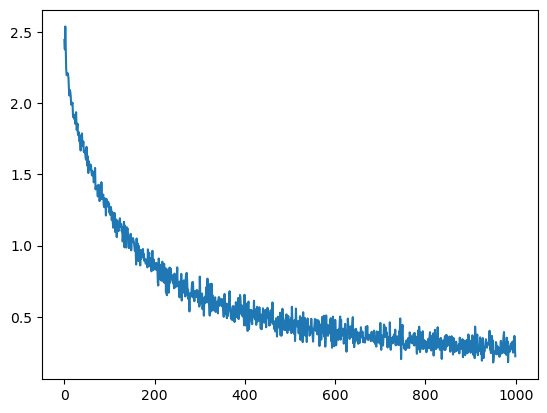

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_history)

In [12]:
from scipy.special import softmax

y_hat_logits = model.predict(X_normed)
y_hat_probs = softmax(y_hat_logits, axis=-1)
y_hat = np.argmax(y_hat_probs, axis=-1)

<Axes: >

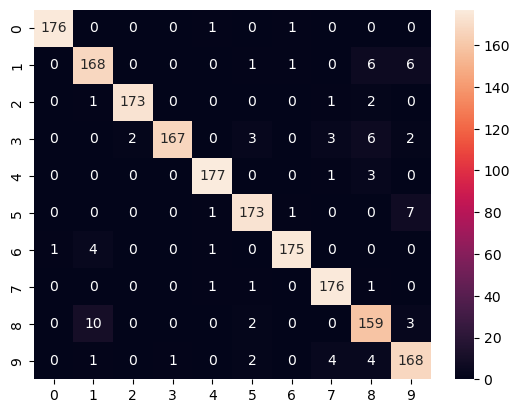

In [13]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y, y_hat), annot=True, fmt="0.0f")